---
title: 2D Laplace
short_title: 
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

This tutorial comes from the following resources:

* 12 Steps to Navier-Stokes - 2D Burgers -[ipynb](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/10_Step_8.ipynb)
* JupyterBook on Iterative Models - [jbook](https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_02_Conjugate_Gradient.html)

**My Notes**:

* I had some serious stability issues from the time stepper. The CFL Condition is important!
* The code started to get a bit cumbersome, so I used a custom state + abstract functions.

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
import lineax as lx

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Diffusion scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = 0
\end{aligned}
$$ (eq:2d_laplace)

Here, we are advised to use a 2nd order accuracy central difference method. 

However, this is a PDE with no time dependence. We have a minimization problem where we want the best $p$ that solves the PDE. More concretely, we have

$$
\begin{aligned}
p^* &= \underset{p}{\text{argmin }}\mathcal{U}(p) \\
&\text{s.t.}\hspace{3mm}\mathcal{U}(p):=\nabla^2p = 0
\end{aligned}
$$

So we need to iteratively solve for this. Basically we will do:

```python
p_0 = ...
p_* = FixedPoint(p_0)
```

## Domain

In [2]:
nx, ny = 41, 41
xmin, ymin = 0.0, 0.0
xmax, ymax = 2.0, 1.0

In [3]:
domain = Domain.from_numpoints(xmin=(xmin, ymin), xmax=(xmax, ymax), N=(nx, ny))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (40, 40)
nDims: 2
Grid Size: (40, 40, 2)
Cell Volume: 0.0012500000000000002


### Initial Conditions

We're doing a very specific initialization which is defined as:

$$
\begin{aligned}
\mathcal{IC}[p] &=
\begin{cases}
0 && \text{for }x=0\\
y && \text{for }x=2\\
\end{cases} \\
\mathcal{IC}\left[\frac{\partial p}{\partial y}\right] &=
0 && \text{for }y=0,1
\end{aligned}
$$


In [4]:
def init_u0(domain):
    """Initial condition from grid"""
    u = jnp.zeros(domain.size, dtype=jnp.float64)

    y = domain.coords[1]

    u = u.at[0, :].set(0)
    u = u.at[-1, :].set(jnp.asarray(y))
    u = u.at[:, 0].set(u[:, 1])
    u = u.at[:, -1].set(u[:, -2])
    return u

In [5]:
u_init = init_u0(domain)

In [6]:
grid = domain.grid

In [7]:
u_init.shape

(40, 40)

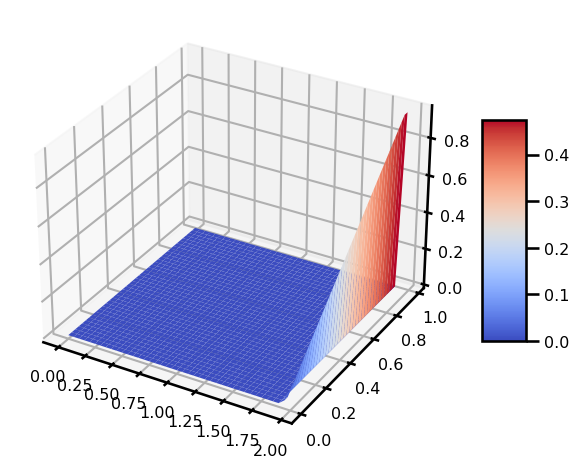

In [8]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    grid[..., 0],
    grid[..., 1],
    u_init,
    cmap=cm.coolwarm,
    # vmin=u_init.min(), vmax=u.max()+0.1*u.max()
)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [9]:
domain.size

(40, 40)

### Boundary Conditions

We are using the same boundary conditions as before, 1's everywhere. 

$$
\begin{aligned}
\mathcal{BC}[u](\mathbf{x}) = \mathcal{BC}[v](\mathbf{x})&= 1 
&& && \mathbf{x}\in\partial\Omega
\end{aligned}
$$

Note, we use the same BCs for both $u$ and $v$.

In [10]:
def bc_fn(u: Array) -> Array:
    y = domain.coords[1]

    u = u.at[0, :].set(0)
    u = u.at[-1, :].set(jnp.asarray(y))
    u = u.at[:, 0].set(u[:, 1])
    u = u.at[:, -1].set(u[:, -2])

    return u

### Equation of Motion

Because we are doing advection, we will use backwards difference for each of the terms.

$$
\begin{aligned}
D^-{2}_x[u] &:= \frac{\partial^2 u}{\partial x^2} \\
D^-{2}_y[u] &:= \frac{\partial^2 u}{\partial y^2} 
\end{aligned}
$$ (eq:2dnadvection)

where $D^2$ is the 2nd order accurate central difference method.

It's starting to get a bit cumbersome to put everything into a single equation, so we will start making functions for each other terms.

#### Laplacian Equation

We have the advection term for both $u$ and $v$:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 0 \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 0
\end{aligned}
$$

They recommend that we use the 1st order accurate backward difference scheme. We will make a generic advection function term that should work for both $u$ and $v$.

In [11]:
from jaxsw._src.operators.functional import elliptical

### Iterative Methods



**Conditions**:

1) Max Iterations are completed
2) Our criteria is met!

### Steepest Descent

In [12]:
from jaxsw._src.utils.linear_solver import steepest_descent
import functools as ft

In [13]:
target_criterion = 1e-6
max_iterations = 100_000
criterion = "l2"
u = init_u0(domain).copy()
b = jnp.zeros_like(u)

matvec_fn = ft.partial(elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=bc_fn)


out = steepest_descent(
    b=b,
    matvec_fn=matvec_fn,
    u_init=u,
    target_criterion=target_criterion,
    max_iterations=max_iterations,
    criterion=criterion,
)
out.iteration, out.loss

(Array(100000, dtype=int64, weak_type=True),
 Array(1.36352081e-05, dtype=float64))

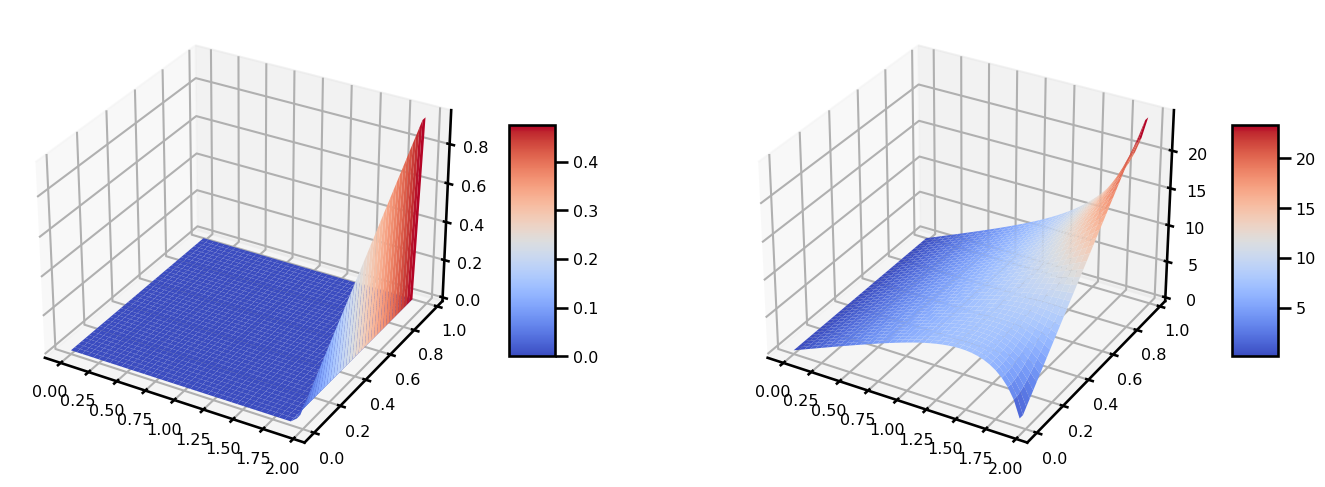

In [14]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})

surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], out.u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

## Conjugate Gradient

In [18]:
from jaxsw._src.utils.linear_solver import steepest_descent, conjugate_gradient
import functools as ft

In [20]:
target_criterion = 1e-5
max_iterations = 1_000
criterion = "l2"
u = init_u0(domain).copy()
b = jnp.zeros_like(u)

matvec_fn = ft.partial(elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=bc_fn)


out = conjugate_gradient(
    b=b,
    matvec_fn=matvec_fn,
    u_init=u,
    target_criterion=target_criterion,
    max_iterations=max_iterations,
    criterion=criterion,
)
out.iteration, out.loss

(Array(1000, dtype=int64, weak_type=True), Array(0.01606126, dtype=float64))

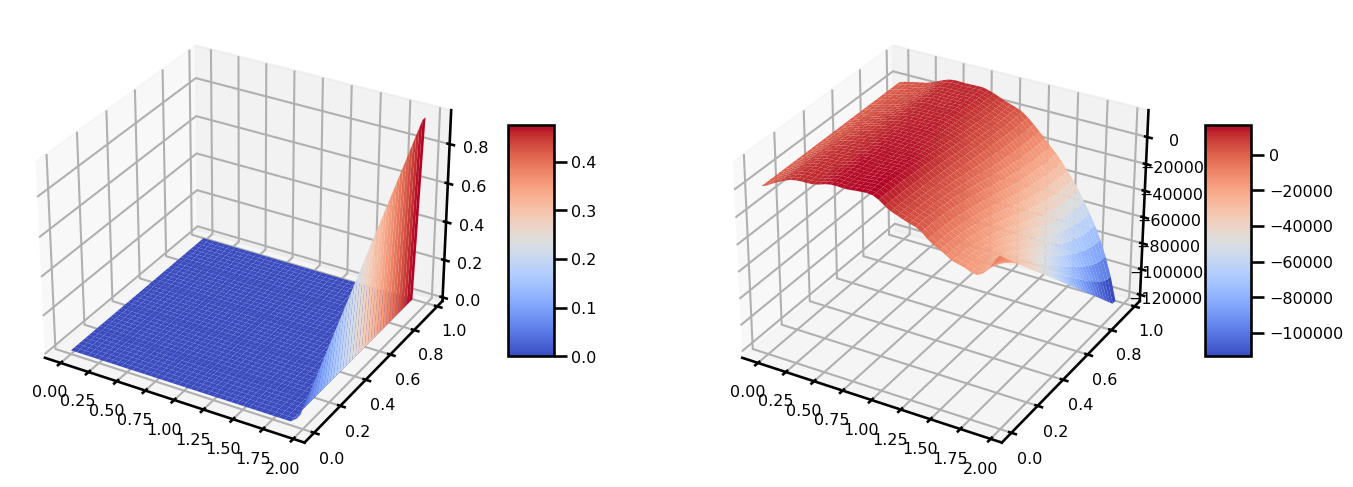

In [21]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})

surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], out.u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [22]:
import lineax as lx

matvec_fn = ft.partial(elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=bc_fn)


u_init = init_u0(domain).copy()
b = jnp.zeros_like(u_init)

in_structure = jax.eval_shape(lambda: u)
operator = lx.FunctionLinearOperator(matvec_fn, in_structure)


solver = lx.NormalCG(rtol=1e-6, atol=1e-6)  # BiCGStab, NormalCG, GMRES, CG
solution = lx.linear_solve(operator, b, solver, options=dict(y0=u_init))
u_out = solution.value

In [27]:
import typing as tp


def lx_linear_solver(matvec_fn: tp.Callable, b, verbose: bool = False):
    in_structure = jax.eval_shape(lambda: u)
    operator = lx.FunctionLinearOperator(matvec_fn, in_structure)
    solver = lx.NormalCG(rtol=1e-6, atol=1e-6)  # BiCGStab, NormalCG, GMRES, CG
    solution = lx.linear_solve(operator, b, solver, options=dict(y0=matvec_fn(b)))
    if verbose:
        print(solution.stats)
    return solution.value


u_init = init_u0(domain).copy()
b = jnp.zeros_like(u_init)

matvec_fn = ft.partial(elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=bc_fn)


u_out = lx_linear_solver(matvec_fn, b)

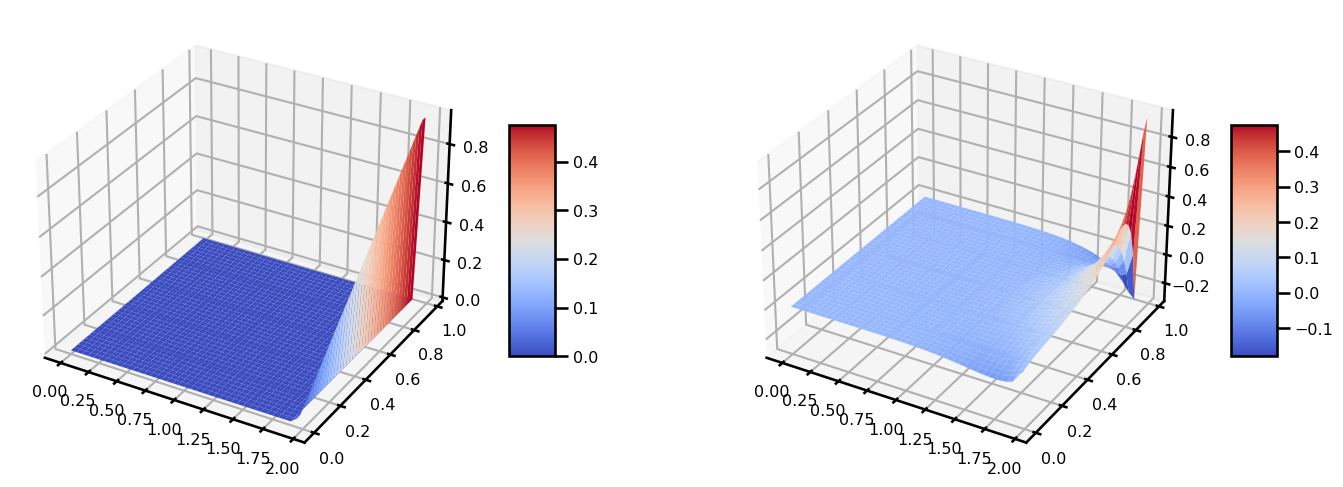

In [28]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u_init, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], u_out, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [33]:
from jaxopt import linear_solve

matvec_fn = ft.partial(elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=bc_fn)

b = jnp.zeros_like(u)
u_out = linear_solve.solve_cg(matvec=matvec_fn, b=b, init=u, maxiter=1_000, tol=1e-6)
# u_out = linear_solve.solve_gmres(matvec=matvec_fn, b=b, init=u, maxiter=100, tol=1e-6)

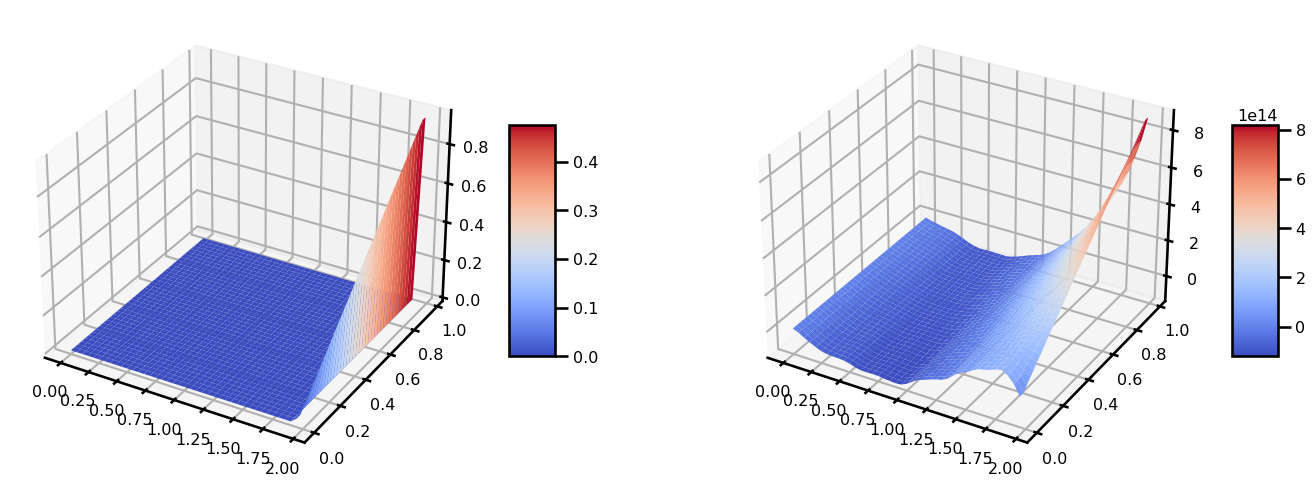

In [34]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u_init, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], u_out, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()